# Face Detection

Hello! In this task you will create your own deep face detector.

First of all, we need import some useful stuff.

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Do you have modern Nvidia [GPU](https://en.wikipedia.org/wiki/Graphics_processing_unit)? There is your video-card model in [list](https://developer.nvidia.com/cuda-gpus) and CUDA capability >= 3.0?

- Yes. You can use it for fast deep learning! In this work we recommend you use tensorflow backend with GPU. Read [installation notes](https://www.tensorflow.org/install/) with attention to gpu section, install all requirements and then install GPU version `tensorflow-gpu`.
- No. CPU is enough for this task, but you have to use only simple model. Read [installation notes](https://www.tensorflow.org/install/) and install CPU version `tensorflow`.

Of course, also you should install `keras`, `matplotlib`, `numpy` and `scikit-image`.

In [2]:
from keras import backend as K

Using TensorFlow backend.


In [3]:
from matplotlib import pyplot as plt
import numpy as np
from skimage import transform

In [4]:
from get_data import load_dataset
from get_data import unpack

In this task we use processed [FDDB dataset](http://vis-www.cs.umass.edu/fddb/). Processing defined in file [./prepare_data.ipynb](prepare_data.ipynb) and consists of:

1. Extract bboxes from dataset. In base dataset face defined by [ellipsis](http://vis-www.cs.umass.edu/fddb/samples/) that not very useful for basic neural network learning.
2. Remove images with big and small faces on one shoot.
3. Re-size images to bounding boxes (bboxes) have same size 32 +/- pixels.

Each image in train, validation and test datasets have shape (176, 176, 3), but part of this image is black background. Interesting image aligned at top left corner.

Bounding boxes define face in image and consist of 5 integer numbers: [image_index, min_row, min_col, max_row, max_col]. Bounding box width and height are 32 +/- 8 pixels wide.

`train_bboxes` and `val_bboxes` is a list of bboxes.

`train_shapes` and `val_shapes` is a list of interesting image shapes.

In [5]:
# First run will download 30 MB data from github

train_images, train_bboxes, train_shapes = load_dataset("data", "train")
val_images, val_bboxes, val_shapes = load_dataset("data", "val")

## Prepare data (1 point)

For learning we should extract positive and negative samples from image.
Positive and negative samples counts should be similar.
Every samples should have same size.

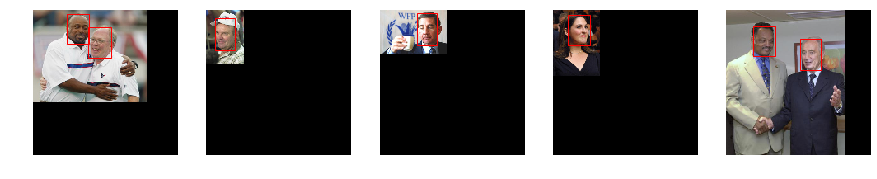

In [6]:
from graph import visualize_bboxes
visualize_bboxes(images=train_images,
                 true_bboxes=train_bboxes)

Every image can represent multiple faces, so we should extract all faces from every images and crop them to `SAMPLE_SHAPE`. This set of extracted images are named `positive`.

Then we chould extract `negative` set. This images should have `SAMPLE_SHAPE` size. Pseudocode for extracting:

    negative_collection := []

    for i in range(negative_bbox_count):
        Select random image.
        image_shape := image_shapes[image_index]
        image_true_bboxes := true_bboxes[true_bboxes[:, 0] == image_index, 1:]
        
        for j in TRY_COUNT: # TRY_COUNT is a magic constant, for example, 100
            Generate new_bbox within image_shape.
            
            if new_bbox is negative bbox for image_true_bboxes:
                Extract from image, new_bbox and resize to SAMPLE_SIZE negative_sample.
                Add negative sample to negative_collection.
                Break # for j in TRY_COUNT

In [7]:
SAMPLE_SHAPE = (32, 32, 3)

In [8]:
import random
from tqdm import tqdm_notebook
random.seed(123)

In [9]:
from scores import iou_score  # https://en.wikipedia.org/wiki/Jaccard_index

def is_negative_bbox(new_bbox, image_bboxes, eps=1e-1):
    """
    Check if new bbox not in true bbox list.
    
    Parameters
    ----------
    new_bbox : np.array, shape (4,)
        The bbox to check on the form
        >>> [min_row, min_col, max_row, max_col]
    image_bboxes : np.array, shape (n_faces, 4)
        Array of the bboxes belonging to the image on the form
        >>> [[min_row_1, min_col_1, max_row_1, max_col_1], [min_row_2, min_col_2, max_row_2, max_col_2]...]
        
    Returns
    -------
    bool
        Wheter or not the new_bbox is a negative (i.e. not overlapping with any face)
    """
    
    for bbox in image_bboxes:
        if iou_score(new_bbox, bbox) >= eps:
            return False
    return True

In [10]:
TRY_COUNT = 1000

In [11]:
def gen_negative_bbox(image, image_shape, image_bboxes):
    """
    Generate negative bbox for image.
    
    Parameters
    ----------
    image : np.array, shape (cols, rows)
        The image under consideration
    image_shape : np.array, shape (2,)
        Part of the image which contains the non-padded image given as rows (from top), columns (from left)
    image_bboxes : np.array, shape (n_faces, 4)
        Array of the bboxes belonging to the image on the form
        >>> [[min_row_1, min_col_1, max_row_1, max_col_1], [min_row_2, min_col_2, max_row_2, max_col_2]...]
        
    Returns
    -------
    success : bool
        Wheter or not a negative was generated for the image
    negative : np.array, shape (*SAMPLE_SHAPE)
        An image not containing enough overlap to be considered as a face
    """
    
    # We choose the negative to be a 32x32 square, just like the faces
    box_size = SAMPLE_SHAPE[0]
    
    # Generate list to randomly select width and height from
    possible_heights = range(image_shape[0] - box_size)
    possible_widths = range(image_shape[1] - box_size)
    
    found = False
    success = True
    count = 0
    
    while not found:
        # Generate new box
        new_min_row = random.choice(possible_heights)
        new_max_row = new_min_row + box_size
        new_min_col = random.choice(possible_widths)
        new_max_col = new_min_col + box_size
        
        new_bbox = [new_min_row, new_min_col, new_max_row, new_max_col]
        
        if is_negative_bbox(new_bbox, image_bboxes):
            negative = image[new_min_row:new_max_row, new_min_col:new_max_col]/255
            success = True
            found = True
            
        count+=1
        
        if count == TRY_COUNT:
            success = False
            negative = np.zeros(SAMPLE_SHAPE)
            break
    
    return success, negative

In [12]:
def get_positive_negative(images, true_bboxes, image_shapes, negative_bbox_count=None):
    """
    Retrieve positive and negative samples from the images.
    
    Parameters
    ----------
    images : list, shape (images, )
        List of the images as a numpy array
    true_bboxes : np.array, shape (faces, 5)
        Bounding boxes belonging to the faces given as
        >>> [corresponding_image_index, min_row, min_col, max_row, max_col]
    image_shapes : array, shape (2,)
        Part of the image file which contains image given as rows (from top), columns (from left)
    negative_bbox_count : None or int
        Number of bboxes to use.
        If None, the number of negative boxes will equal the number of positive boxes
        
    Returns
    -------
    positive : list, shape (len(true_bboxes))
        List of positive bboxes as np.array with shape SAMPLE_SHAPE
    negative : list, shape (negative_bbox_count)
        List of negative bboxes as np.array with shape SAMPLE_SHAPE
    """
    
    positive = []
    negative = []
    image_count = image_shapes.shape[0]
    
    if negative_bbox_count is None:
        negative_bbox_count = len(true_bboxes)
    
    # Extract positive faces
    p_bar = tqdm_notebook(true_bboxes)
    p_bar.set_description("Extracting positive faces")
    for image_index, min_row, min_col, max_row, max_col in p_bar:
        # NOTE: Adding 1 to include the endpoint
        face = images[image_index][min_row:max_row+1, min_col:max_col+1, :]
        positive.append(transform.resize(face, SAMPLE_SHAPE[:2], mode='reflect', anti_aliasing=True))
    
    # Generate negative faces
    image_indices = true_bboxes[:, 0]
    p_bar = tqdm_notebook(range(negative_bbox_count))
    p_bar.set_description("Generating negative faces")
    for i in p_bar:
        success = False
        while not success:
            # Take a random image
            image_index = random.choice(image_indices)
            # Find bounding boxes for this image
            box_indices_this_image = np.where(true_bboxes[:, 0] == image_index)[0]
            image_bboxes = np.array([true_bboxes[i, 1:] for i in box_indices_this_image])
            
            success, neg = gen_negative_bbox(images[image_index],
                                             image_shapes[image_index],
                                             image_bboxes)

        negative.append(neg)
        
    return positive, negative

In [13]:
def get_samples(images, true_bboxes, image_shapes):
    """
    Obtain data samples and target values
    
    Parameters
    ----------
    images : list, shape (images, )
        List of the images as a numpy array
    true_bboxes : np.array, shape (faces, 5)
        Bounding boxes belonging to the faces given as
        >>> [corresponding_image_index, min_row, min_col, max_row, max_col]
    image_shapes : array, shape (images, 2)
        Part of the image file which contains image given as rows (from top), columns (from left)
    
    Returns
    --------
    X : np.array, shape (positive + negative, *SAMPLE_SHAPE)
        Positive and negative samples.
    Y : np.array, shape (positive + negative, 2)
        One hot encoded list of zeros and ones.
        Y[sample_nr, 1] == 1 iff the sample is positive
    """
    positive, negative = get_positive_negative(images=images, 
                                               true_bboxes=true_bboxes, 
                                               image_shapes=image_shapes)
    X = positive
    Y = [[0, 1]] * len(positive)
    
    X.extend(negative)
    Y.extend([[1, 0]] * len(negative))
    
    # NOTE: Cast to float
    return np.array(X), np.array(Y)

Now we can extract samples from images.

In [14]:
X_train, Y_train = get_samples(train_images, train_bboxes, train_shapes)
X_val, Y_val = get_samples(val_images, val_bboxes, val_shapes)

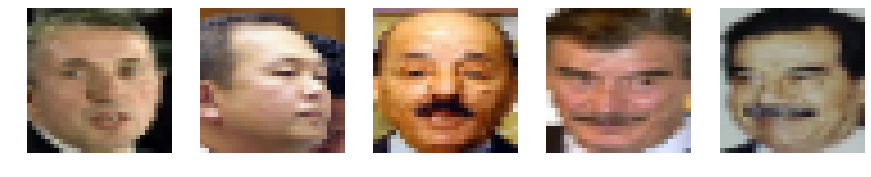

In [15]:
# There we should see faces
from graph import visualize_samples
visualize_samples(X_train[Y_train[:, 1] == 1])

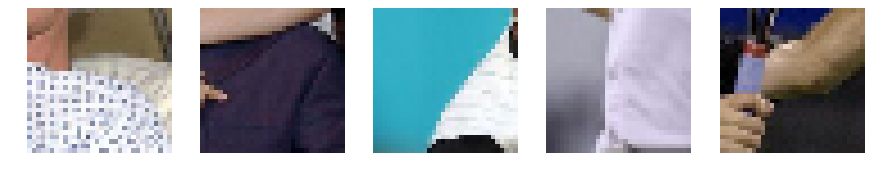

In [16]:
# There we shouldn't see faces
visualize_samples(X_train[Y_train[:, 1] == 0])

## Classifier training (3 points)

First of all, we should train face classifier that checks if face represented on sample.

In [17]:
BATCH_SIZE = 64

### Image augmentation

Important thing in deep learning is augmentation. Sometimes, if your model are complex and cool, you can increase quality by using good augmentation.

Keras provide good [images preprocessing and augmentation](https://keras.io/preprocessing/image/). This preprocessing executes online (on the fly) while learning.

Of course, if you want using samplewise and featurewise center and std normalization you should run this transformation on predict stage. But you will use this classifier to fully convolution detector, in this case such transformation quite complicated, and we don't recommend use them in classifier.

For heavy augmentation you can use library [imgaug](https://github.com/aleju/imgaug). If you need, you can use this library in offline manner (simple way) and online manner (hard way). However, hard way is not so hard: you only have to write [python generator](https://wiki.python.org/moin/Generators), which returns image batches, and pass it to [fit_generator](https://keras.io/models/model/#fit_generator)

In [18]:
from keras.preprocessing.image import ImageDataGenerator # Usefull thing. Read the doc.

datagen = ImageDataGenerator(horizontal_flip=True,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             samplewise_center=True,
                             samplewise_std_normalization=True)
datagen.fit(X_train)

### Fitting classifier

For fitting you can use one of Keras optimizer algorithms. [Good overview](http://ruder.io/optimizing-gradient-descent/)

To choose best learning rate strategy you should read about EarlyStopping and ReduceLROnPlateau or LearningRateScheduler on [callbacks](https://keras.io/callbacks/) page of keras documentation, it's very useful in deep learning.

If you repeat architecture from some paper, you can find information about good optimizer algorithm and learning rate strategy in this paper. For example, every [keras application](https://keras.io/applications/) has link to paper, that describes suitable learning procedure for this specific architecture.

In [19]:
from pathlib import Path
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler

In [20]:
def get_checkpoint(model_name, 
                   output_dir=Path('.').absolute().joinpath('data', 'checkpoints')):
    """
    Returns the model which achieved the best validation score for a given modelname
    
    Parameters
    ----------
    model_name : str
        The name of the model
    output_dir : Path or str
        Name of the output directory
    
    Returns
    -------
    checkpoint_path : str or None
        The checkpoint path given as a string
    """
    
    checkpoints = list(Path(output_dir).glob(f'{model_name}*'))
    checkpoints = [c for c in checkpoints if '.pkl' not in str(c)]
    
    if len(list(checkpoints)) == 0:
        return None
    
    # Sort after lowest validation
    checkpoint = sorted(checkpoints,
                        key=lambda checkpoint: str(checkpoint).split('_')[-1].split('.hdf5')[0])
        
    return str(checkpoint[-1])

In [21]:
from graph import plot_history
import pickle

def fit(model, 
        datagen,
        X_train, 
        Y_train, 
        X_val, 
        Y_val,
        output_dir=Path('.').absolute().joinpath('data', 'checkpoints'),
        epochs=50, 
        lr=0.002,
        verbose=True,
        force_run=False,
        model_name=None,
        early_stop_patience=None,
        lr_on_plateau_patience=None,
        class_weight=None):
    """
    Fits the model.
    
    Parameters
    ----------
    model : Sequential
        The model to fit
    datagen : ImageDataGenerator
        The datagenerator for image augmentation
    X_train : np.array, shape (train, 32, 32, 3)
        The training data
    Y_train : np.array, shape (train, 2)
        The target values
    X_val : np.array, shape (val, 32, 32, 3)
        The validation data
    Y_val : np.array, shape (val, 2)
        The target used for validation
    output_dir : Path or str
        Name of the output directory
    epochs : int
        The number of epochs to use for training
    lr : float or function
        The learning rate
        If lr is a function it must accept epochs and output a learningrate
    verbose : bool
        Whether or not to print summary of the model
    force_run : bool
        Will fit the model, even if a model checkpoint is found
    model_name : str
        Name of model (save name of the model)
    early_stop_patience : int
        Patience for early stop
    lr_on_plateau_patience : int
        Patience for ReduceLROnPlateau
    class_weight : None or dict
        Optional dictionary mapping class indices (integers) to a weight (float) value, 
        used for weighting the loss function (during training only). 
        This can be useful to tell the model to "pay more attention" to samples from an 
        under-represented class
    """
    
    if not output_dir.is_dir():
        output_dir.mkdir(parents=True, exist_ok=True)
        
    if verbose:
        model.summary()

    # Check if the model has already been trained
    checkpoint = get_checkpoint(model_name, output_dir)
    history_path = Path(output_dir).joinpath(f'{model_name}.pkl')
    if model_name is not None and checkpoint is not None and not force_run:
        print(f'Found the best weights stored in {checkpoint}')
        with history_path.open('rb') as f:
            history = pickle.load(f)
            plot_history(history)
        return
        
    if callable(lr):
        init_lr = 0.002
    else:
        init_lr = lr

    model.compile(optimizer=Adam(lr=init_lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    callbacks = []
    
    if model_name is not None:
        callbacks.append(ModelCheckpoint(str(Path(output_dir).joinpath(f'{model_name}')) +
                                 '-{epoch:02d}-{val_loss:.2f}.hdf5',
                                 verbose=1,
                                 save_best_only=True))
        
    if early_stop_patience is not None:
        callbacks.append(EarlyStopping(monitor='val_loss',
                                       patience=early_stop_patience,
                                       verbose=1,
                                       mode='auto',
                                       baseline=None))
        
    if lr_on_plateau_patience is not None:
        callbacks.append(ReduceLROnPlateau(monitor='val_loss',
                                           factor=0.1,
                                           patience=lr_on_plateau_patience, 
                                           verbose=1,
                                           mode='auto', 
                                           min_delta=0.001, 
                                           cooldown=0, 
                                           min_lr=0))
    
    if callable(lr):
        callbacks.append(LearningRateScheduler(lr, verbose=1))
    
    history = model.fit_generator(
        datagen.flow(X_train,
                     Y_train,
                     batch_size=BATCH_SIZE,
                     shuffle=True),
        validation_data=(datagen.standardize(X_val),
                         Y_val),
        epochs=epochs, 
        steps_per_epoch=len(X_train) // BATCH_SIZE,
        callbacks=callbacks,
        class_weight=class_weight)

    with history_path.open('wb') as f:
        pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)
    
    plot_history(history.history)

#### (first point out of three)

![lenet architecture](lenet_architecture.png)
LeCun, Y., Bottou, L., Bengio, Y. and Haffner, P., 1998. Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), pp.2278-2324.

Of course, you can use any another architecture, if want. Main thing is classification quality of your model.

Acceptable validation accuracy for this task is 0.92.

In [22]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D

In [23]:
def lenet(input_shape, dropout=0.3, outputs=2):
    """
    Returns an uncompiled lenet-like model
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    dropout : float
        Degree of dropout
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=20,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=50,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dropout(dropout))
    
    model.add(Dense(outputs, activation='softmax'))
    
    return model

In [24]:
def steroid_lenet(input_shape, dropout=0.3, outputs=2):
    """
    Returns an uncompiled lenet-like model, but with a couple of modifications
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    dropout : float
        Degree of dropout
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
    """
    
    model = Sequential()

    model.add(Conv2D(filters=20,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=50,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=120,
                     kernel_size=5,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))

    model.add(Flatten())
    
    model.add(Dense(800, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Dense(500, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(outputs, activation='softmax'))
    
    return model

In [25]:
def cifar10(input_shape, dropout=0.3, outputs=2):
    """
    Returns an uncompiled cifar10-like model
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    dropout : float
        Degree of dropout
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
        
    References
    ----------
    https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py
    """

    model = Sequential()

    model.add(Conv2D(filters=32,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Dropout(dropout))
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(outputs, activation='softmax'))
    
    return model

In [26]:
def improved_cifar10(input_shape, dropout=0.2, outputs=2):
    """
    Returns an uncompiled cifar10-like model, with an extra dense layer
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    dropout : float
        Degree of dropout
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
        
    References
    ----------
    https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py
    """

    model = Sequential()

    model.add(Conv2D(filters=32,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Conv2D(filters=32,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    model.add(Dropout(dropout))

    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Dropout(dropout))
    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(outputs, activation='softmax'))
    
    return model

In [27]:
def big_cifar10(input_shape, dropout=0.3, outputs=2):
    """
    Returns a large, uncompiled cifar10-like model
    
    Parameters
    ----------
    input_shape : array-like, shape (3,)
        Tuple containing height, width and depth
    dropout : float
        Degree of dropout
    outputs : int
        Number of outputs
    
    Returns
    -------
    model : Sequential
        The uncompiled model
        
    References
    ----------
    https://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/
    """

    model = Sequential()

    
    model.add(Conv2D(filters=32,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     activation='relu',
                     input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
    
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128,
                     kernel_size=3,
                     strides=1,
                     padding='same',
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2,
                           strides=2))
  
    model.add(Dropout(dropout))
    model.add(Flatten())
    
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(outputs, activation='softmax'))
    
    return model

In [28]:
lenet_model = lenet(SAMPLE_SHAPE)
steroid_lenet_model = steroid_lenet(SAMPLE_SHAPE)
cifar10_model = cifar10(SAMPLE_SHAPE)
improved_cifar10_model = improved_cifar10(SAMPLE_SHAPE)
big_cifar10_model = big_cifar10(SAMPLE_SHAPE)

#### Fit the model (second point out of three)

If you doesn't have fast video-card suitable for deep learning, you can first check neural network modifications with small value of parameter `epochs`, for example, 10, and then after selecting best model increase this parameter.
Fitting on CPU can be long, we suggest do it at bedtime.

Don't forget change model name.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 20)        1520      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 50)        25050     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 50)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1600500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
__________

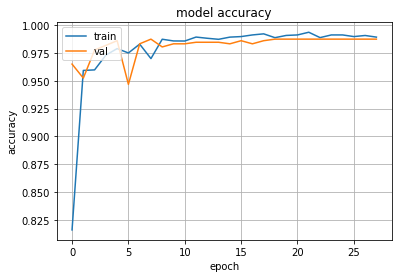

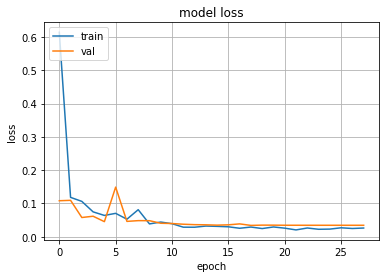

In [29]:
fit(model=lenet_model, 
    datagen=datagen,
    X_train=X_train, 
    X_val=X_val, 
    Y_train=Y_train,
    Y_val=Y_val,
    epochs=50, 
    lr=0.002,
    model_name='lenet',
    early_stop_patience=10,
    lr_on_plateau_patience=3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 20)        1520      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 20)        80        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 20)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 50)        25050     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 50)        200       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 50)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 120)         150120    
__________

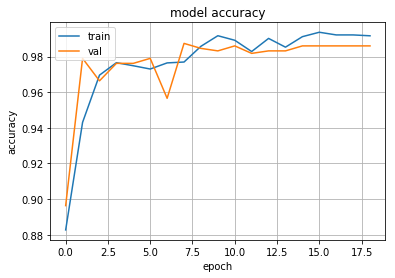

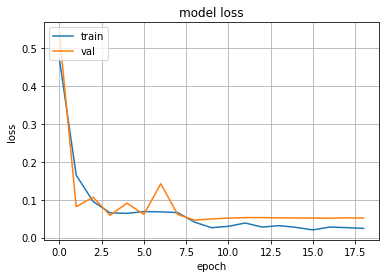

In [30]:
fit(model=steroid_lenet_model, 
    datagen=datagen,
    X_train=X_train, 
    X_val=X_val, 
    Y_train=Y_train,
    Y_val=Y_val,
    epochs=50, 
    lr=0.002,
    model_name='steroid_lenet',
    early_stop_patience=10,
    lr_on_plateau_patience=3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 16, 16, 64)        256       
__________

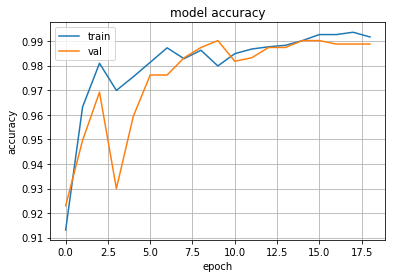

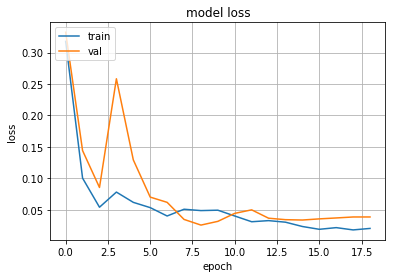

In [31]:
fit(model=cifar10_model, 
    datagen=datagen,
    X_train=X_train, 
    X_val=X_val, 
    Y_train=Y_train,
    Y_val=Y_val,
    epochs=50, 
    lr=0.002,
    model_name='cifar10',
    early_stop_patience=10,
    lr_on_plateau_patience=3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 32)        0         
__________

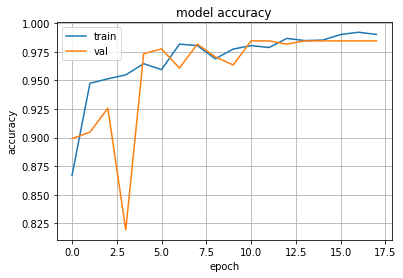

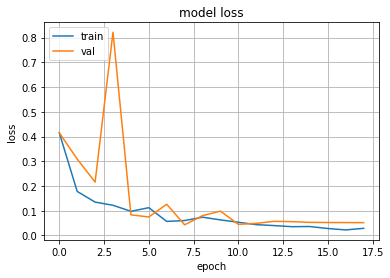

In [32]:
fit(model=improved_cifar10_model, 
    datagen=datagen,
    X_train=X_train, 
    X_val=X_val, 
    Y_train=Y_train,
    Y_val=Y_val,
    epochs=50, 
    lr=0.002,
    model_name='improved_cifar10',
    early_stop_patience=10,
    lr_on_plateau_patience=3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_16 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_17 (Batc (None, 16, 16, 64)        256       
__________

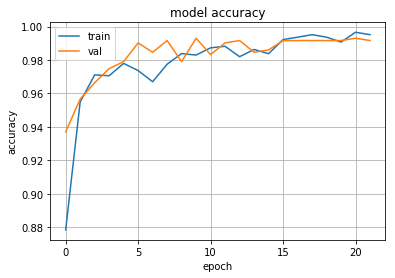

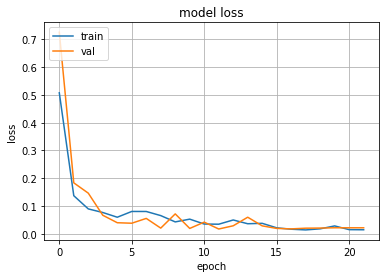

In [33]:
fit(model=big_cifar10_model, 
    datagen=datagen,
    X_train=X_train, 
    X_val=X_val, 
    Y_train=Y_train,
    Y_val=Y_val,
    epochs=50, 
    lr=0.002,
    model_name='big_cifar10',
    early_stop_patience=10,
    lr_on_plateau_patience=3)

#### (third point out of three)

After learning model weights saves in folder `data/checkpoints/`.
Use `model.load_weights(fname)` to load best weights.

If you use Windows and Model Checkpoint doesn't work on your configuration, you should implement [your own Callback](https://keras.io/callbacks/#create-a-callback) to save best weights in memory and then load it back.

In [34]:
# NOTE: get_checkpoint is defined above for use in fit
model = cifar10_model
model.load_weights(get_checkpoint('cifar10'))

## Detection

If you have prepared classification architecture with high validation score, you can use this architecture for detection.

Convert classification architecture to fully convolution neural network (FCNN), that returns heatmap of activation.

### Detector model or sliding window (1 point)

Now you should replace fully-connected layers with $1 \times 1$ convolution layers.

Every fully connected layer perform operation $f(Wx + b)$, where $f(\cdot)$ is nonlinear activation function, $x$ is layer input, $W$ and $b$ is layer weights. This operation can be emulated with $1 \times 1$ convolution with activation function $f(\cdot)$, that perform exactly same operation $f(Wx + b)$.

If there is `Flatten` layer with $n \times k$ input size before fully connected layers, convolution should have same $n \times k$ input size.
Multiple fully connected layers can be replaced with convolution layers sequence.

After replace all fully connected layers with convolution layers, we get fully convolution network. If input shape is equal to input size of previous network, output will have size $1 \times 1$. But if we increase input shape, output shape automatically will be increased. For example, if convolution step of previous network strides 4 pixels, increase input size with 100 pixels along all axis makes increase outputsize with 25 values along all axis. We got activation map of classifier without necessary extract samples from image and multiple calculate low-level features.

In total:
1. $1 \times 1$ convolution layer is equivalent of fully connected layer.
2. $1 \times 1$ convolution layers can be used to get activation map of classification network in "sliding window" manner.

We propose replace last fully connected layer with softmax actiovation to convolution layer with linear activation.It will be usefull to find good treshold. Of course, you can use softmax activation.

#### Example of replace cnn head:

##### Head before convert

![before replace image](before_convert.png)

##### Head after convert

![before replace image](after_convert.png)

On this images displayed only head. `InputLayer` should be replaced with convolution part exit.
Before convert network head takes fifty $8 \times 8$ feature maps and returns two values: probability of negative and positive classes. This output can be considered as activation map with size $1 \times 1$.

If input have size $8 \times 8$, output after convert would have $1 \times 1$ size, but input size is $44 \times 44$.
After convert network head returns one $37 \times 37$ activation map.

In [35]:
IMAGE_SHAPE = (176, 176, 3)

In [36]:
def generate_fcnn_model(model, input_shape, last_activation='linear', verbose=True):
    """
    Generate a fully convolutional neural network from a network with part conv layers and part fc layers
    
    Notes
    -----
    See
    http://cs231n.github.io/convolutional-networks/#convert
    for better explaination
    
    Parameters
    ----------
    input_shape : tuple, shape (3,)
        The input shape for the model
    model : Sequantial
        The model to transform
    last_activation : str
        The activation for the last layer
    verbose : bool
        Whether or not to print the summary
    
    Returns
    -------
    new_model : Sequential
        The uncompiled transformed model
        
    References
    ----------
    An alternative way of doing this, including setting weights
    https://stackoverflow.com/questions/41161021/how-to-convert-a-dense-layer-to-an-equivalent-convolutional-layer-in-keras
    """
    
    prev_layer_flatten = False
    
    new_model = Sequential()

    # Special case for first layer
    layer_conf = model.layers[0].get_config()
    new_model.add(Conv2D(filters=layer_conf['filters'],
                         kernel_size=layer_conf['kernel_size'],
                         strides=layer_conf['strides'],
                         padding=layer_conf['padding'],
                         activation=layer_conf['activation'],
                         input_shape=input_shape))
    
    # Loop through all intermediate layers
    for layer in model.layers[1:-1]:
        layer_name = str(layer).split('.')[-1].split(' ')[0]
        layer_conf = layer.get_config()
        
        if layer_name == 'Dropout':
            new_model.add(Dropout(layer.get_config()['rate']))
        elif layer_name == 'BatchNormalization':
            new_model.add(BatchNormalization())
        elif layer_name == 'Conv2D':
            new_model.add(Conv2D(filters=layer_conf['filters'],
                                 kernel_size=layer_conf['kernel_size'],
                                 strides=layer_conf['strides'],
                                 padding=layer_conf['padding'],
                                 activation=layer_conf['activation']))
        elif layer_name == 'MaxPooling2D':
            new_model.add(MaxPooling2D(pool_size=layer_conf['pool_size'],
                                       strides=layer_conf['strides']))
        elif layer_name == 'Flatten':
            prev_layer_flatten = True
            flatten_kernel_size = layer.input_shape[1]
        elif layer_name == 'Dense':
            if prev_layer_flatten:
                # Flattening is replaced with a filter-size equaling the last filter size before the flattening 
                # layer, keeping the number of filters constant
                # NOTE: Padding must be set to valid in order for the dimensions to match
                new_model.add(Conv2D(filters=layer_conf['units'],
                                     kernel_size=flatten_kernel_size,
                                     strides=1,
                                     padding='valid',
                                     activation=layer_conf['activation']))
                prev_layer_flatten = False
            else:
                # Dense layer with x nodes will be replaced with x 1x1 filters
                new_model.add(Conv2D(filters=layer_conf['units'],
                                     kernel_size=1,
                                     strides=1,
                                     padding='valid',
                                     activation=layer_conf['activation']))                
        else:
            raise NotImplementedError(f'{layer_name} not implemented')

    # Special case for last layer as we may want linear activation
    new_model.add(Conv2D(filters=model.layers[-1].get_config()['units'],
                         kernel_size=1,
                         strides=1,
                         padding='valid',
                         activation=last_activation))            
            
    if verbose:
        new_model.summary()
    
    return new_model

In [37]:
fcnn_model = generate_fcnn_model(model, IMAGE_SHAPE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 176, 176, 32)      896       
_________________________________________________________________
batch_normalization_23 (Batc (None, 176, 176, 32)      128       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 176, 176, 32)      9248      
_________________________________________________________________
batch_normalization_24 (Batc (None, 176, 176, 32)      128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 88, 88, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 88, 88, 64)        18496     
_________________________________________________________________
batch_normalization_25 (Batc (None, 88, 88, 64)        256       
__________

#### (1 point)

Then you should write function that copy weights from classification model to fully convolution model.
Convolution weights may be copied without modification, fully-connected layer weights should be reshaped before copy.

Pay attention to last layer.

In [38]:
def copy_weights(base_model, fcnn_model):
    """
    Copy weigths from a model with a mixture of convolution and dense layers 
    to the equivalent consisting of only covolutional layers.
    
    Parameters
    ----------
    base_model : Sequential
        The models to copy the weights from
    fcnn_model : Sequential
        The model to copy the weights to
    """
    
    base_config = base_model.get_config()
    fcnn_config = fcnn_model.get_config()
    
    # We operate with two counters: Whenever there are Flattening layers, the fcnn counter will lag by one
    j = 0
    for i in range(len(base_config)):
        base_name = base_config[i]['class_name']
        fcnn_name = fcnn_config[j]['class_name']
        
        if base_name == fcnn_name:
            fcnn_model.layers[j].set_weights(base_model.layers[i].get_weights())
        elif base_name == 'Flatten':
            # NOTE: j will not be updated
            continue
        elif base_name == 'Dense' and fcnn_name == 'Conv2D':
            fcnn_w_dims = fcnn_model.layers[j].get_weights()[0].shape
            fcnn_b_dims = fcnn_model.layers[j].get_weights()[1].shape
            
            new_w_b = [base_model.layers[i].get_weights()[0].reshape(fcnn_w_dims),
                       base_model.layers[i].get_weights()[1].reshape(fcnn_b_dims)]
            
            fcnn_model.layers[j].set_weights(new_w_b)
        else:
            raise RuntimeError(f'Mismatch of layers base {i}: {base_name}, fcnn {j}: {fcnn_name}')
        
        j += 1

In [39]:
copy_weights(base_model=model, fcnn_model=fcnn_model)

### Model visualization

In [40]:
from graph import visualize_heatmap

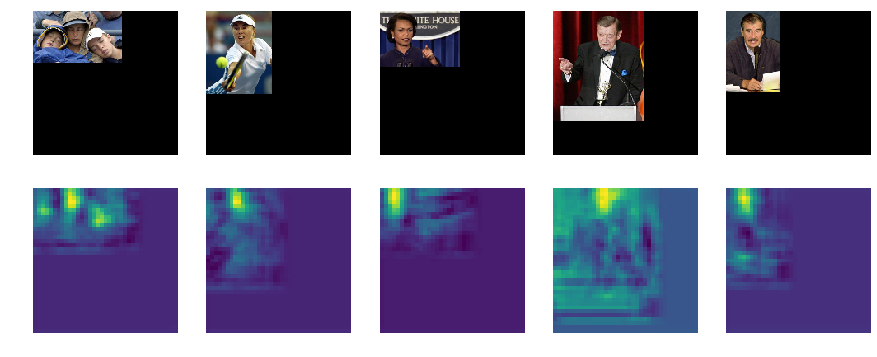

In [41]:
predictions = fcnn_model.predict(datagen.standardize(np.array(val_images)[:6, ...].astype(float)))
visualize_heatmap(val_images, predictions[:, :, :, 1])

### Detector (1 point)

First detector part is getting bboxes and decision function.
Greater decision function indicates better detector confidence.

This function should return pred_bboxes and decision_function:

- `pred bboxes` is list of 5 int tuples like `true bboxes`: `[image_index, min_row, min_col, max_row, max_col]`.
- `decision function` is confidence of detector for every pred bbox: list of float values, `len(decision function) == len(pred bboxes)` 
 
We propose resize image to `IMAGE_SHAPE` size, find faces on resized image with `SAMPLE_SHAPE` size and then resize them back.

In [42]:
def get_fccn_predictions(fcnn_model, images):
    """
    Returns the predicted bounding boxes and decision functions
    
    Parameters
    ----------
    fcnn : Sequential
        The full CNN model to use for prediction
    images : list, shape (n_images, )
        List of images, where each element is a np.array with shape (width, height, 3)
        
    Returns
    -------
    fcnn_predictions : np.array, shape (n_images, n_cols, n_rows, 2)
        Predictions from the full-cnn model
    """
    
    # NOTE: Ternary operator as the result of a list comprehension
    resized_images = np.array([transform.resize(image,
                                                IMAGE_SHAPE,
                                                mode="reflect",
                                                anti_alias=True)
                               if image.shape != IMAGE_SHAPE else
                               image for image in images])

    # Predict
    fcnn_predictions = fcnn_model.predict(datagen.standardize(resized_images.astype(float)))
    
    return fcnn_predictions

In [43]:
# Detection
from skimage.feature import peak_local_max

def get_bboxes_and_decision_function(fcnn_predictions, image_shapes):
    """
    Returns the predicted bounding boxes and decision functions
    
    Parameters
    ----------
    fcnn_predictions : np.array, shape (n_images, n_cols, n_rows, 2)
        Predictions from the full-cnn model
    image_shapes : array, shape (images, 2)
        Part of the image file which contains image given as rows (from top), columns (from left)
        
    Returns
    -------
    pred_bboxes : list, shape (n_pred_face, )
        List of all predictions.
        Each element is on the form [image_index, min_row, min_col, max_row, max_col]
    decision_function : list, shape (n_pred_face, )
        List of confidence for every predicted bounding box
    """    
    pred_bboxes, decision_function = [], []
    
    pred_shape = fcnn_predictions[0, :, :, 0].shape
    
    # Pick the prediction for true face (i.e. index 1)
    for i, prediction in enumerate(fcnn_predictions[:, :, :, 1]):
        coordinates = peak_local_max(prediction,
                                     min_distance=1,
                                     indices=True,
                                     num_peaks=8)
        
        for h, w in coordinates:
            image_index = i
            
            confidence = prediction[h, w]
            
            # Rescale the height and the width
            h = np.round(h*IMAGE_SHAPE[1]/pred_shape[1]).astype(int)
            w = np.round(w*IMAGE_SHAPE[0]/pred_shape[0]).astype(int)
            
            # NOTE: peak_local_max does not return the center of the max,
            #       but rather the upper left edge of the blob
            min_row = (h).clip(0, IMAGE_SHAPE[1])
            max_row = (h + SAMPLE_SHAPE[1]).clip(0, IMAGE_SHAPE[1])
            min_col = (w).clip(0, IMAGE_SHAPE[0])
            max_col = (w + SAMPLE_SHAPE[0]).clip(0, IMAGE_SHAPE[0])
            
            
            pred_bboxes.append((image_index, min_row, min_col, max_row, max_col))
            decision_function.append(confidence)
            
    return pred_bboxes, decision_function

#### Detector visualization

In [44]:
fcnn_predictions_val = get_fccn_predictions(fcnn_model=fcnn_model, images=val_images)

In [45]:
pred_bboxes_val, decision_function_val = get_bboxes_and_decision_function(fcnn_predictions=fcnn_predictions_val,
                                                                          image_shapes=val_shapes)

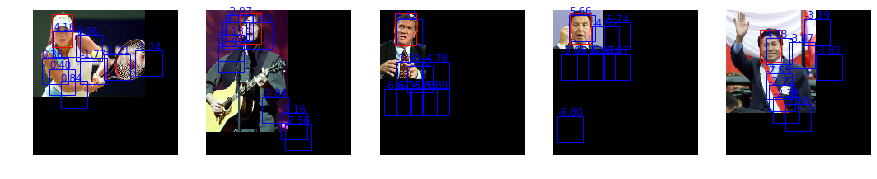

In [46]:
visualize_bboxes(images=val_images,
                 pred_bboxes=pred_bboxes_val,
                 true_bboxes=val_bboxes,
                 decision_function=decision_function_val)

## Detector score (1 point)

Write [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) graph.

You can use function `best_match` to extract matching between prediction and ground truth, false positive and false negative samples. Pseudo-code for calculation precision and recall graph:
    
    # Initialization for first step threshold := -inf
    tn := 0 # We haven't any positive sample
    fn := |false_negative| # But some faces wasn't been detected
    tp := |true_bboxes| # All true bboxes have been caught
    fp := |false_positive| # But also some false positive samples have been caught
    
    Sort decision_function and pred_bboxes with order defined by decision_function
    y_true := List of answers for "Is the bbox have matching in y_true?" for every bbox in pred_bboxes
    
    for y_on_this_step in y_true:
        # Now we increase threshold, so some predicted bboxes makes positive.
        # If y_t is True then the bbox is true positive else bbox is false positive
        # So we should
        Update tp, tn, fp, fn with attention to y_on_this_step
        
        Add precision and recall point calculated by formula through tp, tn, fp, fn on this step
        Threshold for this point is decision function on this step.

In [47]:
def precision_recall_curve(pred_bboxes, true_bboxes, decision_functions, overlap_threshold=0.1):
    """
    Generates the precision and recall for a corresponding decision function
    
    Parameters
    ----------
    pred_bboxes : list, shape (n_pred_face, 5)
        List of all predictions.
        Each element is on the form [image_index, min_row, min_col, max_row, max_col]
    true_bboxes : np.array, shape (n_faces, 5)
        Bounding boxes belonging to the faces given as
        >>> [corresponding_image_index, min_row, min_col, max_row, max_col]
    decision_functions : list, shape (n_pred_face, )
        List of confidence for every predicted bounding box
    overlap_treshold : float
        IoU-threshold for true positive
        
    Returns
    -------
    precisions : list, shape (n_pred_face, )
        List of the precisions corresponding to a treshold of the decision boundray
    recalls : list, shape (n_pred_face, )
        List of the recalls corresponding to a treshold of the decision boundray
    thresholds : list, shape (n_pred_face, )
        List of the tresholds of the decision boundray
    """
    precisions = []
    recalls = []
    thresholds = []

    # Sort the decision function in descending order
    # NOTE: The indices of the pred_bboxes are sorted together with the pred_bboxes
    #       In this way, we can find the best matching predicted box to an image 
    #       (the one with the highest decision_function)
    #       On hit, we mark the true_bbox as found so that only one prediction can match a true_bbox for all
    #       decision_functions
    decision_functions, pred_bboxes = zip(*sorted(zip(decision_functions, pred_bboxes), reverse=True))
    
    true_bbox_image_indices = np.array([true_bbox[0] for true_bbox in true_bboxes], dtype=int)

    num_true_bboxes = true_bboxes.shape[0]
    tp = 0
    fp = 0
    
    # Loop over all predictions
    for prediction_bbox, decision_function in zip(pred_bboxes, decision_functions):
        cur_image_index = prediction_bbox[0]
        
        # Find true_bboxes which matches cur_image_index
        matching_pred_indices = np.where(true_bbox_image_indices == cur_image_index)[0]
        true_bbox_candidates = true_bboxes[matching_pred_indices]
        
        max_overlap = 0
        index_with_max_overlap = None
        for true_box_index, true_bbox_candidate in enumerate(true_bbox_candidates):
            match_score = iou_score(true_bbox_candidate[1:], prediction_bbox[1:])
            if match_score > max_overlap:
                max_overlap = match_score
                index_with_max_overlap = true_box_index

        if max_overlap > overlap_threshold:
            tp += 1
            # Match the true bounding box as found (so that it will not be found in matching_pred_indices)
            # I.e. there can be no other candidates with lower decision_function that can match this true_bbox
            true_bbox_image_indices[matching_pred_indices[index_with_max_overlap]] = -1
        else:
            fp += 1
            
        # n_true_bboxes = tp + fn 
        # fn = n_true_bboxes - tp 
        fn = len(true_bbox_image_indices) - tp
        
        # NOTE: Adding machine epsilon to avoid division by 0
        pre = tp / (tp+fp+np.finfo(float).eps)
        rec = tp / (tp+fn+np.finfo(float).eps)
        
        precisions.append(pre)
        recalls.append(rec)
        thresholds.append(decision_function)
    
    return precisions, recalls, thresholds

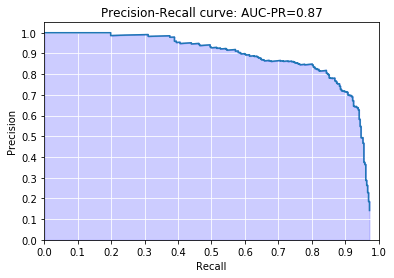

In [48]:
from graph import plot_precision_recall
precision_val, recall_val, thresholds_val = precision_recall_curve(pred_bboxes=pred_bboxes_val, 
                                                                   true_bboxes=val_bboxes,
                                                                   decision_functions=decision_function_val)
plot_precision_recall(precision=precision_val, recall=recall_val)

### Threshold (1 point)

Next step in detector creating is select threshold for decision_function.
Every possible threshold presents point on recall-precision graph.

Select threshold for `recall=0.85`.

In [49]:
def get_threshold(thresholds, recall, match_recall=0.85):
    """
    Obtain a threshold value where the recall is the closest, but at least equal to match_recall
    
    Notes
    -----
    thresholds must be sorted in descending order
    
    Parameters
    -----------
    thresholds : list, shape (n_pred_face, )
        List of the tresholds of the decision boundray
    recalls : list, shape (n_pred_face, )
        List of the recalls corresponding to a treshold of the decision boundray 
    match_recall : float
        Value which should at least be matched
        
    Returns
    -------
    threshold : float
        The threshold which matches the criteria stated above
    """
    
    possible_thresholds = np.where(np.array(recall) >= match_recall)[0]
    threshold = thresholds[possible_thresholds[0]]
    
    return threshold

THRESHOLD = get_threshold(thresholds_val, recall_val)

In [50]:
def detect(pred_bboxes, decision_function, threshold, return_decision=True):
    """
    Get bboxes with decision_function not lesser than the threshold.

    Parameters
    ----------
    pred_bboxes : list, shape (n_pred_face, )
        List of all predictions.
        Each element is on the form [image_index, min_row, min_col, max_row, max_col]
    decision_function : list, shape (n_pred_face, )
        List of confidence for every predicted bounding box
    threshold : float
        The threshold on the decision_function for valid bboxes
    return_decision : bool
        If True, the valid desicions are returned
    
    Returns
    -------
    threshold : float
        The threshold which matches the criteria stated above
    """

    valid_ind = np.where(np.array(decision_function) >= threshold)[0]
    result_decision = np.array(decision_function)[valid_ind]
    result = np.array(pred_bboxes)[valid_ind]
    
    if return_decision:
        return result, result_decision
    else:
        return result

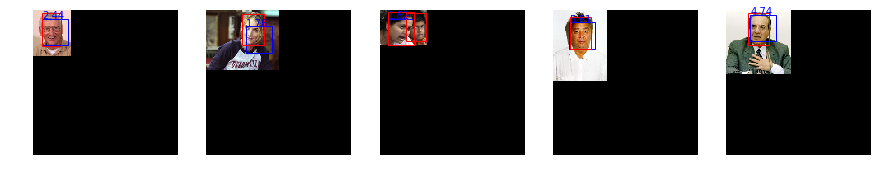

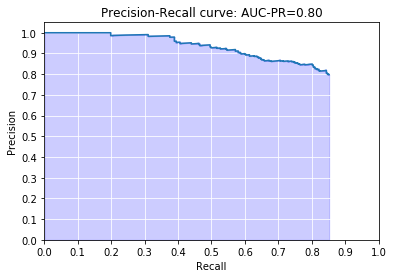

In [51]:
pred_bboxes, decision_function = detect(pred_bboxes=pred_bboxes_val,
                                        decision_function=decision_function_val,
                                        threshold=THRESHOLD, 
                                        return_decision=True)

visualize_bboxes(images=val_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=val_bboxes,
                 decision_function=decision_function
                )

precision, recall, thresholds = precision_recall_curve(pred_bboxes=pred_bboxes, 
                                                       true_bboxes=val_bboxes, 
                                                       decision_functions=decision_function)
plot_precision_recall(precision=precision, 
                      recall=recall)

## Test dataset (1 point)

Last detector preparation step is testing.

Attention: to avoid over-fitting, after testing algorithm you should run [./prepare_data.ipynb](prepare_data.ipynb), and start all fitting from beginning.

Detection score (in graph header) should be 0.85 or greater.

In [52]:
test_images, test_bboxes, test_shapes = load_dataset("data", "test")

In [53]:
# We test get_bboxes_and_decision_function becouse we want pay attention to all recall values
fcnn_predictions_test = get_fccn_predictions(fcnn_model=fcnn_model, images=test_images)

In [54]:
pred_bboxes_test, decision_function_test = get_bboxes_and_decision_function(fcnn_predictions=fcnn_predictions_test,
                                                                            image_shapes=test_shapes)

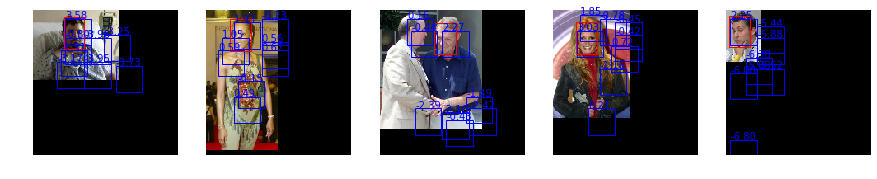

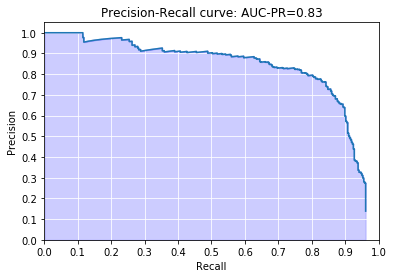

In [55]:
visualize_bboxes(images=test_images,
                 pred_bboxes=pred_bboxes_test,
                 true_bboxes=test_bboxes,
                 decision_function=decision_function_test)

precision_test, recall_test, _ = precision_recall_curve(pred_bboxes=pred_bboxes_test, 
                                                        true_bboxes=test_bboxes, 
                                                        decision_functions=decision_function_test)
plot_precision_recall(precision=precision_test, 
                      recall=recall_test)

## Optional tasks

### Real image dataset

Test your algorithm on original (not scaled) data.
Visualize bboxes and plot precision-recall curve.

In [ ]:
# First run will download 523 MB data from github

original_images, original_bboxes, original_shapes = load_dataset("data", "original")

In [ ]:
# Write code here
# ...


## Hard negative mining

Upgrade the score with [hard negative mining](https://www.reddit.com/r/computervision/comments/2ggc5l/what_is_hard_negative_mining_and_how_is_it/).

A hard negative is when you take that falsely detected patch, and explicitly create a negative example out of that patch, and add that negative to your training set. When you retrain your classifier, it should perform better with this extra knowledge, and not make as many false positives.

In [ ]:
# Write this function
def hard_negative(train_images, image_shapes, train_bboxes, X_val, Y_val, base_model, fcnn_model):
    pass

In [ ]:
hard_negative(train_images=train_images, image_shapes=train_shapes, train_bboxes=train_bboxes, X_val=X_val, Y_val=Y_val, base_model=model, fcnn_model=fcnn_model)

In [ ]:
model.load_weights("data/checkpoints/...")

In [ ]:
copy_weights(base_model=model, fcnn_model=fcnn_model)

pred_bboxes, decision_function = get_bboxes_and_decision_function(fcnn_model=fcnn_model, images=val_images, image_shapes=val_shapes)

visualize_bboxes(images=val_images,
                 pred_bboxes=pred_bboxes,
                 true_bboxes=val_bboxes,
                 decision_function=decision_function
                )

precision, recall, thresholds = precision_recall_curve(pred_bboxes=pred_bboxes, true_bboxes=val_bboxes, decision_function=decision_function)
plot_precision_recall(precision=precision, recall=recall)

### Multi scale detector

Write and test detector with [pyramid representation][pyramid].
[pyramid]: https://en.wikipedia.org/wiki/Pyramid_(image_processing)

1. Resize images to predefined scales.
2. Run detector with different scales.
3. Apply non-maximum supression to detection on different scales.

References:
1. [E. H. Adelson,C. H. Anderson, J. R. Bergen, P. J. Burt, J. M. Ogden: Pyramid methods in image processing](http://persci.mit.edu/pub_pdfs/RCA84.pdf)
2. [PETER J. BURT, EDWARD H. ADELSON: The Laplacian Pyramid as a Compact Image Code](http://persci.mit.edu/pub_pdfs/pyramid83.pdf)

In [ ]:
def multiscale_detector(fcnn_model, images, image_shapes):
    return []

### Next  step

Next steps in deep learning detection are R-CNN, Faster R-CNN and SSD architectures.
This architecture realization is quite complex.
For this reason the task doesn't cover them, but you can find the articles in the internet.